# ITE GPy testing

First start by defining function to load the data created by py_map_elites and define ITE constants

Put the right controller dimension and behavior dimension (dim_ctrl, dim_x)


In [1]:
from copy import *
from math import *
import numpy as np
import sys
import GPy as GPy

#Load the CVT voronoi centroids from input archive
def load_centroids(filename):
	points = np.loadtxt(filename)
	return points
#Load map data from archive
def load_data(filename, dim,dim_ctrl):
	print("Loading ",filename)
	data = np.loadtxt(filename)
	fit = data[:, 0:1]
	desc = data[:,1: dim+1]
	x = data[:,dim+1:dim+1+dim_ctrl]
	return fit, desc, x

############### ITE CONSTANTS ######################################################
alpha = 0.9
kappa = 0.03
rho = 0.4
variance_noise_square = 0.001
dim_ctrl = 24 #ctrl dimension
dim_x = 16 #descriptor dimension
episode_duration = 10
random = 0 #Put this to 1 to use random strategy instead of ITE


Now parse the maps info, don't forget to put the right path for the centroids and archive files.

In [2]:
################# PARSE INFO TO GET THE MAP ########################################
centroids = load_centroids("/home/eloise/MAPS/learn_minitaur/current30_xy14_2/1/centroids_40000_16.dat")
fits, descs, ctrls = load_data("/home/eloise/MAPS/learn_minitaur/current30_xy14_2/1/archive_20000.dat", centroids.shape[1],dim_ctrl)
n_fits = []
n_descs = []
n_ctrls = []

for i in range(0,len(fits)):
    #if(fits[i]>1):
    if(1):
        n_fits.append(fits[i])
        n_descs.append(descs[i])
        n_ctrls.append(ctrls[i])
n_fits = np.array(n_fits)
n_descs = np.array(n_descs)
n_ctrls = np.array(n_ctrls)

n_fits_real = np.array(n_fits)
n_descs_real = np.array(n_descs)
n_ctrls_real = np.array(n_ctrls)

fits_saved = copy(n_fits)

print ("Max in the map : ", max(n_fits))
print("Associated ctrl index : ", np.argmax(n_fits))



Loading  /home/eloise/MAPS/learn_minitaur/current30_xy14_2/1/archive_20000.dat
Max in the map :  [4.55414197]
Associated ctrl index :  129


Now gather data for the GP. 

X will be the descriptor to test.

We start by the descriptor associated with the max fitness found in the map.

Y will be the fitness difference between the simulation and testing environment. Here we use a random diff

In [3]:
global X,Y
X= []
Y= []

for i in range(0,1):
    index =  np.random.randint(0,len(fits_saved))
    X.append(n_descs[index])
    Y.append(-np.random.rand(1)*3-0.5)
X = np.array(X)
Y = np.array(Y)
print(X)
print(Y)

[[0.43381277 0.55927822 0.76736456 0.33795371 0.38497982 0.68528519
  0.30302539 0.57688192 0.04922116 0.75057151 0.79550695 1.
  0.67530292 0.86127359 0.58909014 0.91480904]]
[[-2.32947412]]


Define the GP with a Matern52 kernel, the same lenghtscale is used for every descriptor dimension

In [4]:
ker = GPy.kern.Matern52(dim_x,lengthscale = rho, ARD=False) + GPy.kern.White(dim_x,np.sqrt(variance_noise_square))
m = GPy.models.GPRegression(X,Y,ker)


Now that the GP is defined we can predict the GP output (difference between the simulation and testing environement)

In [5]:
means, variances = m.predict(n_descs) #GP prediction over the descriptors
print(means)

[[-0.00224649]
 [-0.01467458]
 [-0.00201707]
 ...
 [-0.00430657]
 [-0.00297083]
 [-0.01875259]]


Let's define the upper confidence bound acquisition function for the bayesian optimisation part.

In [6]:
def UCB(mu_map,kappa,sigma_map):
	GP = []
	for i in range(0,len(mu_map)):
		GP.append(mu_map[i] + kappa*sigma_map[i])
	return np.argmax(GP)

Add the predicted difference to the data in order to recover the predicted mean (and not the difference)

In [7]:
for j in range(0,len(n_fits_real)):
    n_fits_real[j] = means[j] + n_fits[j]

Now let's use the UCB function to choose the next controller to test

In [8]:
next_it = UCB(n_fits_real,kappa,variances)

In [9]:
print(next_it)
print(n_fits_real[next_it])
print(n_fits[next_it])
print(n_descs_real[next_it])

129
[4.5515657]
[4.55414197]
[0.25442056 0.50770486 0.28526394 0.31414752 0.01832532 0.51750237
 0.65393484 0.33415057 0.63933978 0.09348094 0.43709739 0.36617698
 0.36896755 0.18458346 0.1368122  0.25425081]


Let's plot the data

In [10]:
import matplotlib.pyplot as plt
import numpy as np
def plot_mu_sigma(mu_map, sigma_map):
	# Visualize the result
	le = len(mu_map)
	tmp = mu_map.reshape((le,))

	tmp_sampled = []
	sigma_sampled = []
	for i in range(0,le):
		if(i%50==0):
			tmp_sampled.append(tmp[i])
			sigma_sampled.append(sigma_map[i][0])
	tmp_sampled = np.array(tmp_sampled)
	sigma_sampled = np.array(sigma_sampled)
	plt.plot(range(0,len(tmp_sampled)), tmp_sampled, 'or')
	plt.fill_between(range(0,len(tmp_sampled)), tmp_sampled-sigma_sampled, tmp_sampled+sigma_sampled, color='gray', alpha=0.2)
	plt.show()

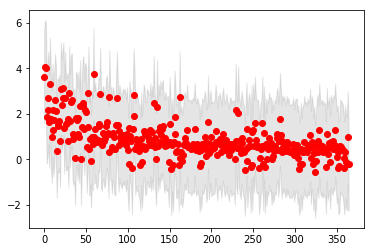

In [11]:
plot_mu_sigma(n_fits_real, variances)

We can then iterate again the process, UCB has found the next controller to test. We can test it and append to X and Y the newly collected data. You can run the following section a few times to see the output

In [23]:
X = np.vstack((X,n_descs[next_it]))

In [24]:
X

array([[0.43381277, 0.55927822, 0.76736456, 0.33795371, 0.38497982,
        0.68528519, 0.30302539, 0.57688192, 0.04922116, 0.75057151,
        0.79550695, 1.        , 0.67530292, 0.86127359, 0.58909014,
        0.91480904],
       [0.25442056, 0.50770486, 0.28526394, 0.31414752, 0.01832532,
        0.51750237, 0.65393484, 0.33415057, 0.63933978, 0.09348094,
        0.43709739, 0.36617698, 0.36896755, 0.18458346, 0.1368122 ,
        0.25425081],
       [0.47237191, 0.17852552, 0.530066  , 0.35377839, 0.57377196,
        0.04835711, 0.32654132, 0.32640184, 0.49451115, 0.49927289,
        0.12199267, 0.23384406, 0.10653204, 0.3299778 , 0.01398947,
        0.04072041]])

In [25]:
Y = np.vstack((Y,-np.random.rand(1)*3-0.5))

In [26]:
Y

array([[-2.32947412],
       [-2.96520064],
       [-2.18653774]])

In [27]:
ker = GPy.kern.Matern52(dim_x,lengthscale = rho, ARD=False) + GPy.kern.White(dim_x,np.sqrt(variance_noise_square))
m = GPy.models.GPRegression(X,Y,ker)

In [28]:
means, variances = m.predict(n_descs)

In [29]:
for j in range(0,len(n_fits_real)):
    n_fits_real[j] = means[j] + n_fits[j]

In [30]:
next_it = UCB(n_fits_real,kappa,variances)

In [31]:
print(next_it)
print(n_fits_real[next_it])
print(n_fits[next_it])
print(n_descs_real[next_it])

68
[4.06055006]
[4.23513462]
[0.49655943 0.35760756 0.46881496 0.48793854 0.61058478 0.24034377
 0.38804504 0.40812625 0.08271557 0.61146816 0.4534585  0.16888734
 0.04403967 0.36911773 0.51782524 0.04198885]


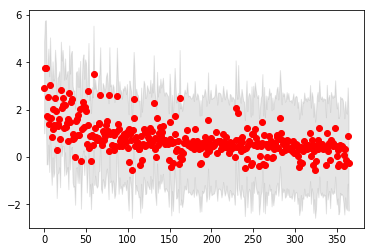

In [32]:
plot_mu_sigma(n_fits_real, variances)

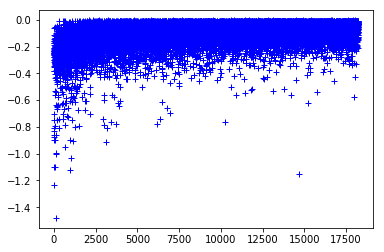

In [33]:
x = range(0,len(n_descs))
y = copy(means)
e = copy(variances)
plt.plot(x, y,'b+')
plt.show()

This is the processed used to run IT&E